In [3]:
#!pip install scikit_posthocs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp
from datetime import datetime

In [4]:
fear_greed = pd.read_csv('/content/drive/MyDrive/ds_Kaipa Anish Reddy/csv_files/fear_greed_index.csv')  # Adjust path as needed
historical = pd.read_csv('/content/drive/MyDrive/ds_Kaipa Anish Reddy/csv_files/historical_data.csv')

In [5]:
# Basic EDA
print(historical.head())
print(historical.info())
print(historical.describe())
print("Missing Values:\n", historical.isnull().sum())
print("Unique Accounts:", historical['Account'].nunique())
print("Unique Coins:", historical['Coin'].unique())
print("Sides:", historical['Side'].value_counts())
print("Directions:", historical['Direction'].value_counts())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [6]:
# Date parsing
historical['Date'] = pd.to_datetime(historical['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce').dt.date
historical['Date'] = pd.to_datetime(historical['Date'])
fear_greed['date'] = pd.to_datetime(fear_greed['date'])

In [7]:
# Merge
merged_df = pd.merge(historical, fear_greed[['date', 'value', 'classification']], left_on='Date', right_on='date', how='left')
merged_df.drop('date', axis=1, inplace=True)
merged_df['classification'].fillna('Unknown', inplace=True)

/tmp/ipython-input-875314184.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['classification'].fillna('Unknown', inplace=True)


In [8]:
# Profitability (handle zero Size USD)
merged_df['Closed PnL'] = pd.to_numeric(merged_df['Closed PnL'], errors='coerce').fillna(0)
merged_df['profitability_percent'] = np.where(merged_df['Size USD'] != 0, (merged_df['Closed PnL'] / merged_df['Size USD']) * 100, 0)

In [9]:
# Filter outliers (e.g., extreme PnL > 3 std dev)
pnl_mean = merged_df['Closed PnL'].mean()
pnl_std = merged_df['Closed PnL'].std()
merged_df = merged_df[(merged_df['Closed PnL'] > pnl_mean - 3 * pnl_std) & (merged_df['Closed PnL'] < pnl_mean + 3 * pnl_std)]

In [10]:
# Grouped stats: Avg Profitability by Sentiment
avg_profit_by_sentiment = merged_df.groupby('classification')['profitability_percent'].mean().reset_index()
print("Avg Profitability by Sentiment:\n", avg_profit_by_sentiment)


Avg Profitability by Sentiment:
   classification  profitability_percent
0   Extreme Fear               0.390385
1  Extreme Greed               4.727378
2           Fear               1.471004
3          Greed               1.897528
4        Neutral               0.938764
5        Unknown              54.448059


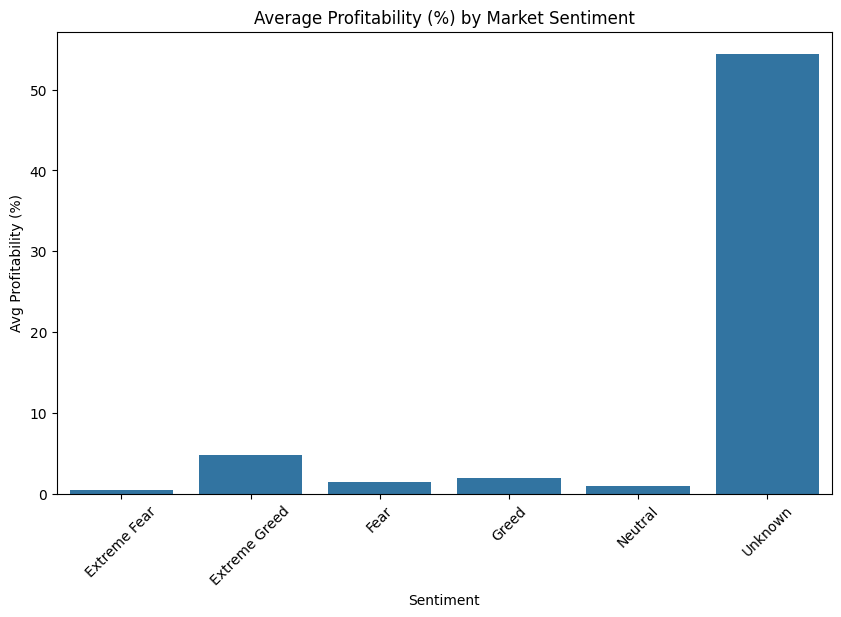

In [12]:
# Plot: Avg Profitability by Sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x='classification', y='profitability_percent', data=avg_profit_by_sentiment)
plt.title('Average Profitability (%) by Market Sentiment')
plt.ylabel('Avg Profitability (%)')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.savefig('/content/drive/MyDrive/ds_Kaipa Anish Reddy/outputs/avg_profit_by_sentiment.png')
plt.show()


In [13]:
  # Additional Analysis 1: Win/Loss Ratio and Risk (PnL Std Dev) by Sentiment
merged_df['Win'] = merged_df['Closed PnL'] > 0
win_rate = merged_df.groupby('classification')['Win'].mean() * 100
pnl_std = merged_df.groupby('classification')['Closed PnL'].std()
risk_metrics = pd.concat([win_rate, pnl_std], axis=1).rename(columns={'Win': 'Win Rate (%)', 'Closed PnL': 'PnL Std Dev'})
print("Risk Metrics by Sentiment:\n", risk_metrics)

Risk Metrics by Sentiment:
                 Win Rate (%)  PnL Std Dev
classification                           
Extreme Fear       36.919683   208.969834
Extreme Greed      46.319411   190.724548
Fear               41.903324   183.491853
Greed              38.325613   173.158571
Neutral            39.619980   162.710793
Unknown           100.000000   489.139068


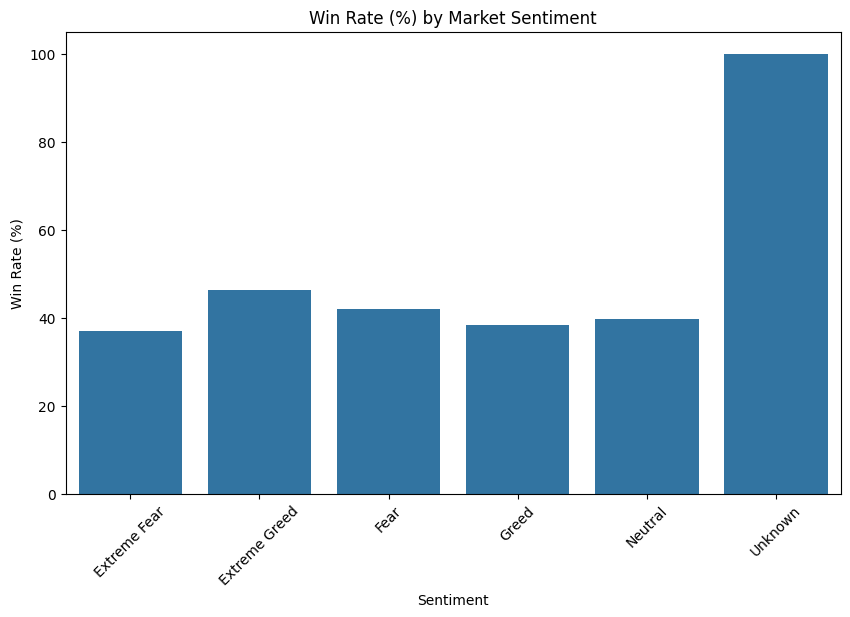

In [14]:
# Plot: Win Rate by Sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x=win_rate.index, y=win_rate.values)
plt.title('Win Rate (%) by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.savefig('/content/drive/MyDrive/ds_Kaipa Anish Reddy/outputs/win_rate_by_sentiment.png')
plt.show()


In [16]:
# Additional Analysis 2: Trade Volume and Frequency by Sentiment
volume_by_sentiment = merged_df.groupby('classification')['Size USD'].agg(['sum', 'mean', 'count']).rename(columns={'sum': 'Total Volume USD', 'mean': 'Avg Volume USD', 'count': 'Trade Count'})
print("Volume by Sentiment:\n", volume_by_sentiment)



Volume by Sentiment:
                 Total Volume USD  Avg Volume USD  Trade Count
classification                                               
Extreme Fear        1.059314e+08     4972.604469        21303
Extreme Greed       1.197032e+08     3006.332883        39817
Fear                4.348119e+08     7060.125102        61587
Greed               2.665708e+08     5322.474752        50084
Neutral             1.614700e+08     4297.043214        37577
Unknown             1.470600e+03      735.300000            2


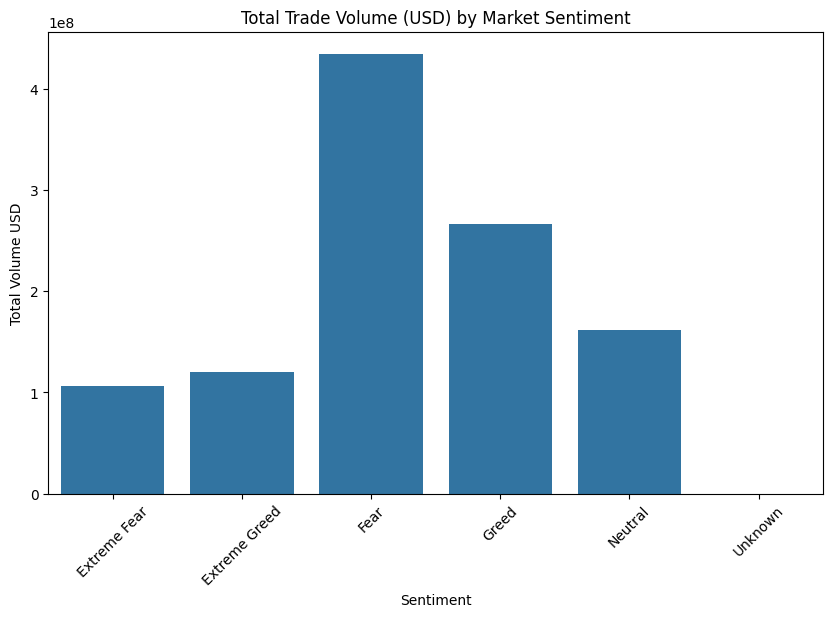

In [17]:
# Plot: Total Volume by Sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x=volume_by_sentiment.index, y=volume_by_sentiment['Total Volume USD'])
plt.title('Total Trade Volume (USD) by Market Sentiment')
plt.ylabel('Total Volume USD')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.savefig('/content/drive/MyDrive/ds_Kaipa Anish Reddy/outputs/total_volume_by_sentiment.png')
plt.show()

In [18]:
# Additional Analysis 3: Per-Trader Performance
account_pnl = merged_df.groupby(['Account', 'classification'])['Closed PnL'].agg(['sum', 'mean', 'count']).unstack(fill_value=0)
print("Per-Account PnL by Sentiment:\n", account_pnl)

Per-Account PnL by Sentiment:
                                                       sum                 \
classification                               Extreme Fear  Extreme Greed   
Account                                                                    
0x083384f897ee0f19899168e3b1bec365f52a9012    9482.221441  -21898.652574   
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd   -1231.822296   31621.022957   
0x271b280974205ca63b716753467d5a371de622ab   16706.884912    1793.160215   
0x28736f43f1e871e6aa8b1148d38d4994275d72c4  -14161.226959  103613.097941   
0x2c229d22b100a7beb69122eed721cee9b24011dd   11415.247787   77844.433569   
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  -48183.866780   30300.575513   
0x39cef799f8b69da1995852eea189df24eb5cae3c  -61481.989810   14406.384865   
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6     110.553364    9815.397369   
0x420ab45e0bd8863569a5efbb9c05d91f40624641     199.956900    4019.618590   
0x430f09841d65beb3f27765503d0f850b8bce7713       0.000000

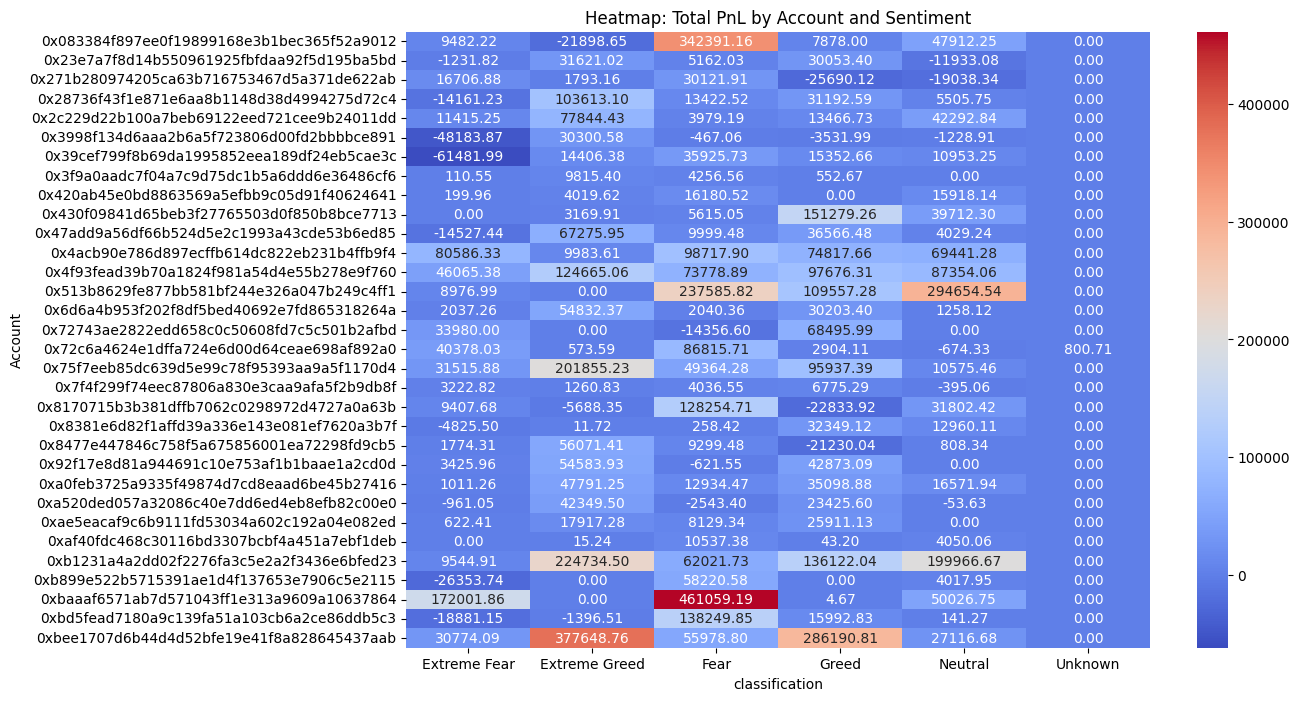

In [20]:
# Plot: Heatmap of Total PnL by Account and Sentiment (if many accounts)
if len(account_pnl) > 1:
    plt.figure(figsize=(12, 8))
    sns.heatmap(account_pnl['sum'], annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Heatmap: Total PnL by Account and Sentiment')
    plt.savefig('/content/drive/MyDrive/ds_Kaipa Anish Reddy/outputs/account_pnl_heatmap.png')
    plt.show()

In [21]:
# Additional Analysis 4: Buy/Sell Behavior by Sentiment
side_by_sentiment = pd.crosstab(merged_df['classification'], merged_df['Side'], normalize='index') * 100
print("Buy/Sell % by Sentiment:\n", side_by_sentiment)

Buy/Sell % by Sentiment:
 Side                   BUY       SELL
classification                       
Extreme Fear     51.096090  48.903910
Extreme Greed    44.943115  55.056885
Fear             48.943771  51.056229
Greed            48.786039  51.213961
Neutral          50.307369  49.692631
Unknown         100.000000   0.000000


In [22]:
# Statistical Tests (your code, refined)
groups = [merged_df.loc[merged_df['classification'] == sentiment, 'profitability_percent'] for sentiment in merged_df['classification'].unique()]
anova_stat, anova_p = stats.f_oneway(*groups)
print(f"ANOVA: F-statistic={anova_stat:.4f}, p-value={anova_p:.4f}")
kruskal_stat, kruskal_p = stats.kruskal(*groups)
print(f"Kruskal-Wallis: H-statistic={kruskal_stat:.4f}, p-value={kruskal_p:.4f}")
posthoc = sp.posthoc_dunn(merged_df, val_col='profitability_percent', group_col='classification', p_adjust='bonferroni')
print("\nPost-hoc Dunn's Test (p-values):\n", posthoc)

ANOVA: F-statistic=577.2108, p-value=0.0000
Kruskal-Wallis: H-statistic=1997.7481, p-value=0.0000

Post-hoc Dunn's Test (p-values):
                 Extreme Fear  Extreme Greed           Fear         Greed  \
Extreme Fear    1.000000e+00  1.169344e-273   3.459438e-46  4.516781e-07   
Extreme Greed  1.169344e-273   1.000000e+00  2.345812e-182  0.000000e+00   
Fear            3.459438e-46  2.345812e-182   1.000000e+00  9.415733e-30   
Greed           4.516781e-07   0.000000e+00   9.415733e-30  1.000000e+00   
Neutral         5.603752e-13  1.667743e-234   3.380681e-13  6.121806e-02   
Unknown         9.146326e-02   3.072890e-01   1.481661e-01  1.109394e-01   

                     Neutral   Unknown  
Extreme Fear    5.603752e-13  0.091463  
Extreme Greed  1.667743e-234  0.307289  
Fear            3.380681e-13  0.148166  
Greed           6.121806e-02  0.110939  
Neutral         1.000000e+00  0.120476  
Unknown         1.204757e-01  1.000000  


In [23]:
# Daily Aggregates for Patterns
daily = merged_df.groupby('Date').agg({'Closed PnL': 'sum', 'Size USD': 'sum', 'value': 'mean'}).reset_index()
correlation_pnl_sentiment = daily['Closed PnL'].corr(daily['value'])
print(f"Correlation PnL and Fear/Greed Value: {correlation_pnl_sentiment:.2f}")

Correlation PnL and Fear/Greed Value: -0.10


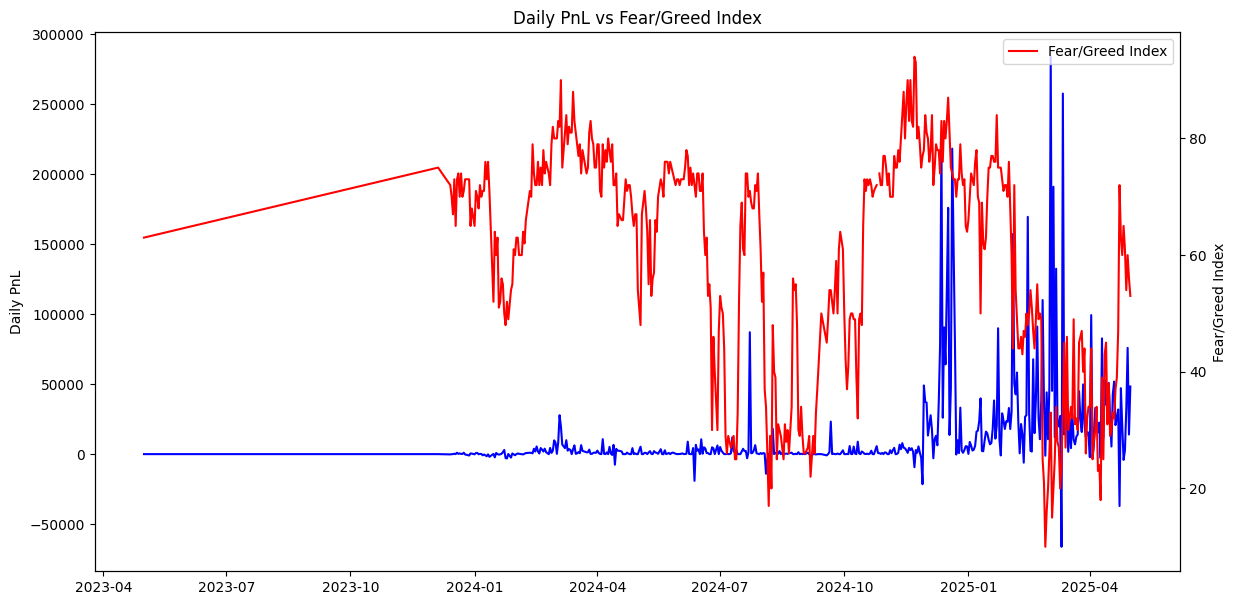

In [24]:
# Plot: Daily PnL vs Sentiment
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(daily['Date'], daily['Closed PnL'], color='blue', label='Daily PnL')
ax1.set_ylabel('Daily PnL')
ax2 = ax1.twinx()
ax2.plot(daily['Date'], daily['value'], color='red', label='Fear/Greed Index')
ax2.set_ylabel('Fear/Greed Index')
plt.title('Daily PnL vs Fear/Greed Index')
plt.legend()
plt.savefig('/content/drive/MyDrive/ds_Kaipa Anish Reddy/outputs/daily_pnl_vs_sentiment.png')
plt.show()


In [25]:
# Exports
merged_df.to_csv('/content/drive/MyDrive/ds_Kaipa Anish Reddy/csv_files/merged_data.csv', index=False)
volume_by_sentiment.to_csv('/content/drive/MyDrive/ds_Kaipa Anish Reddy/csv_files/volume_by_sentiment.csv')
account_pnl.to_csv('/content/drive/MyDrive/ds_Kaipa Anish Reddy/csv_files/account_pnl.csv')
posthoc.to_csv('/content/drive/MyDrive/ds_Kaipa Anish Reddy/csv_files/posthoc_results.csv')